In [1]:
# Cell 1 — imports
import os, json
from pathlib import Path
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import spectral as sp

from skimage.filters import threshold_otsu, gaussian, laplace, sobel
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, closing, rectangle
from scipy.ndimage import binary_fill_holes, distance_transform_edt
from scipy.signal import find_peaks
from skimage.transform import warp_polar
import matplotlib.patches as patches

In [2]:
# Cell 2 — configuration
INPUT_ROOT  = Path("data")        # <-- set to folder that holds your scans
OUTPUT_ROOT = Path("results")     # one main output root

# discover scans
HDR_LIST = sorted(INPUT_ROOT.rglob("*_raw_rad_float32.hdr"))
print(f"Found {len(HDR_LIST)} scans")
for i, p in enumerate(HDR_LIST):
    print(f"[{i}] {p}")

# choose ONE scan by index (no run_all)
SELECT_IDX = 0                   # <-- change index as needed
assert len(HDR_LIST) > 0, "No *_raw_rad_float32.hdr found under INPUT_ROOT"
HDR_PATH = HDR_LIST[SELECT_IDX]
SCAN_ID  = HDR_PATH.stem

# per-scan folders
ODIR_ROOT    = OUTPUT_ROOT / SCAN_ID
ODIR_IMG     = ODIR_ROOT / "images"
ODIR_CUBES   = ODIR_ROOT / "cubes"
ODIR_RESULTS = ODIR_ROOT / "results"
ODIR_LOGS    = ODIR_ROOT / "logs"
for d in (ODIR_IMG, ODIR_CUBES, ODIR_RESULTS, ODIR_LOGS):
    d.mkdir(parents=True, exist_ok=True)

# parameters
WHITE_PATCH_HALF = 20   # 40x40 patch for white-panel center
EPS = 1e-6

print("Selected HDR:", HDR_PATH)
print("Output root:", ODIR_ROOT.resolve())


Found 28 scans
[0] data\_SWIR_384_SN3151_4000us_2025-08-27T105238_raw_rad_float32.hdr
[1] data\_SWIR_384_SN3151_4500us_2025-06-25T093940_raw_rad_float32.hdr
[2] data\_SWIR_384_SN3151_4500us_2025-06-25T110341_raw_rad_float32.hdr
[3] data\_SWIR_384_SN3151_4500us_2025-06-25T111659_raw_rad_float32.hdr
[4] data\DEJP01D-Small-1_SWIR_384_SN3151_4000us_2025-08-27T141450_raw_rad_float32.hdr
[5] data\DEJP01D-Small-2_SWIR_384_SN3151_4000us_2025-08-27T141747_raw_rad_float32.hdr
[6] data\DEJP08D-Left_SWIR_384_SN3151_4000us_2025-08-27T131636_raw_rad_float32.hdr
[7] data\DEJP08D-Middle_SWIR_384_SN3151_4000us_2025-08-27T124738_raw_rad_float32.hdr
[8] data\DEJP08D-Middle_SWIR_384_SN3151_4000us_2025-08-27T132402_raw_rad_float32.hdr
[9] data\DEOE03D-1_SWIR_384_SN3151_4000us_2025-08-27T133810_raw_rad_float32.hdr
[10] data\DEOE03D-2_SWIR_384_SN3151_4000us_2025-08-27T134157_raw_rad_float32.hdr
[11] data\DEOE09D-Small_SWIR_384_SN3151_4000us_2025-08-27T140738_raw_rad_float32.hdr
[12] data\EMJP01D-1_SWIR_384_S

In [3]:
# Cell 3 — load cube + wavelengths (nm)
img = sp.envi.open(str(HDR_PATH))
cube = img.load().astype(np.float32)     # raw radiance (camera usually dark-corrected)
H, W, B = cube.shape
print("Cube shape:", cube.shape)

try:
    wavs = np.array([float(w) for w in img.bands.centers], dtype=np.float32)
except Exception as e:
    raise RuntimeError("Wavelengths missing in header; required for nm-based band picking.") from e

print("Wavelength range (nm):", float(wavs[0]), "→", float(wavs[-1]))


Cube shape: (2230, 384, 288)
Wavelength range (nm): 953.3067626953125 → 2515.764404296875


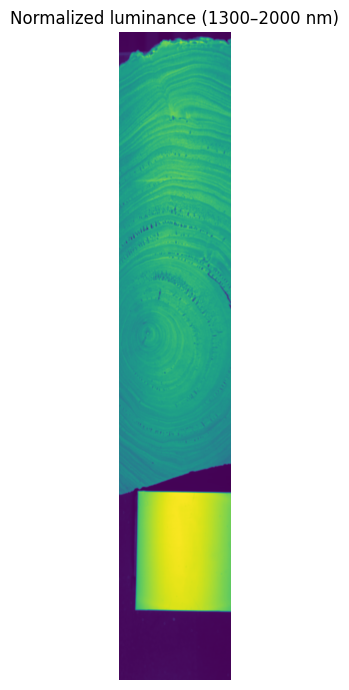

In [4]:
# Cell 4 — luminance for white-panel search
mask_sw = (wavs >= 1300) & (wavs <= 2000)
if mask_sw.sum() < 10:
    mask_sw = np.ones(B, dtype=bool)

lum = cube[:, :, mask_sw].mean(axis=2)
lumN = (lum - np.nanmin(lum)) / (np.nanmax(lum) - np.nanmin(lum) + 1e-9)

plt.figure(figsize=(5,7))
plt.imshow(lumN, vmin=0, vmax=1)
plt.title("Normalized luminance (1300–2000 nm)")
plt.axis("off")
plt.tight_layout()
# plt.savefig(ODIR_IMG / "luminance_1300_2000.png", dpi=200)
plt.show()


C:\Users\mubut0522\AppData\Local\Temp\ipykernel_33144\2896045020.py:4: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  bw = closing(bw, rectangle(5, 5))


Candidate bright regions: 1


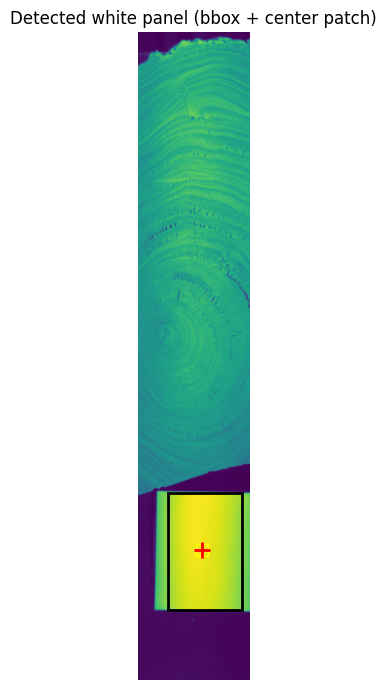

Panel bbox: (1584, 103, 1990, 358) center: (1782, 222) patch: (1762, 1802, 202, 242)


In [5]:
# Cell 5 — threshold + region pick + center patch
t = threshold_otsu(lumN)
bw = lumN > max(t, 0.85)
bw = closing(bw, rectangle(5, 5))
bw = remove_small_objects(bw, min_size=2000)
lab = label(bw)
regions = regionprops(lab)
print("Candidate bright regions:", len(regions))
if not regions:
    raise RuntimeError("No bright region found for white panel. Adjust thresholding.")

best, best_score = None, -1.0
for r in regions:
    minr, minc, maxr, maxc = r.bbox
    area = (maxr-minr)*(maxc-minc)
    if area < 3000:
        continue
    mean_val = lumN[minr:maxr, minc:maxc].mean()
    score = mean_val + 0.1*(r.centroid[0]/H)  # tiny bias downward (common panel placement)
    if score > best_score:
        best_score, best = score, r

minr, minc, maxr, maxc = best.bbox
cy, cx = map(int, best.centroid)

r0, r1 = max(0, cy-WHITE_PATCH_HALF), min(H, cy+WHITE_PATCH_HALF)
c0, c1 = max(0, cx-WHITE_PATCH_HALF), min(W, cx+WHITE_PATCH_HALF)

fig = plt.figure(figsize=(5,7))
plt.imshow(lumN, vmin=0, vmax=1)
plt.title("Detected white panel (bbox + center patch)")
ax = plt.gca()
ax.add_patch(patches.Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, lw=2))
ax.add_patch(patches.Rectangle((c0, r0), c1-c0, r1-r0, fill=False, color='yellow'))
ax.plot(cx, cy, 'r+', ms=12, mew=2)
plt.axis("off")
plt.tight_layout()
plt.savefig(ODIR_IMG / "white_panel_detection.png", dpi=200)
plt.show()

print("Panel bbox:", (minr, minc, maxr, maxc), "center:", (cy, cx), "patch:", (r0, r1, c0, c1))


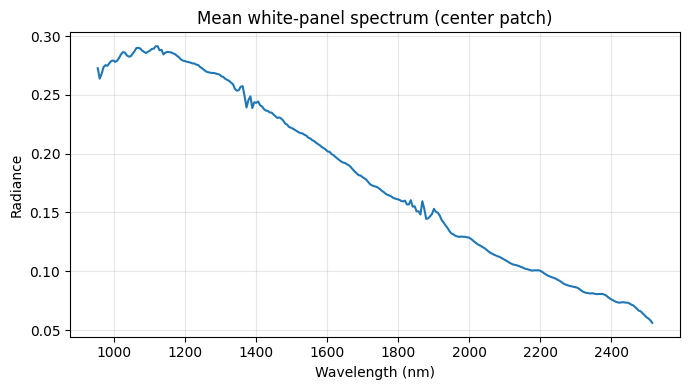

Wspec stats min/median/max: 0.0561649352312088 0.17212708294391632 0.29136472940444946


In [6]:
# Cell 6 — mean white spectrum from center patch
white_patch = cube[r0:r1, c0:c1, :]
Wspec = np.nanmean(white_patch.reshape(-1, B), axis=0).astype(np.float32)

plt.figure(figsize=(7,4))
plt.plot(wavs, Wspec)
plt.title("Mean white-panel spectrum (center patch)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Radiance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(ODIR_IMG / "white_panel_spectrum.png", dpi=200)
plt.show()

print("Wspec stats min/median/max:",
      float(np.nanmin(Wspec)), float(np.nanmedian(Wspec)), float(np.nanmax(Wspec)))


In [7]:
# Cell 7 — reflectance for FULL image
# satmask_path = str(HDR_PATH).replace(".hdr", "_satmask.hdr")
# sat_any = np.zeros((H, W), dtype=bool)
# if os.path.exists(satmask_path):
#     sat = sp.envi.open(satmask_path).load()
#     sat_any = (sat > 0).any(axis=2) if sat.ndim == 3 else (sat > 0)

# reflect = cube / (Wspec[None, None, :] + EPS)
# reflect = np.where(sat_any[..., None], np.nan, reflect)
# reflect = np.clip(reflect, 0, 1.5).astype(np.float32)

# print("Reflectance FULL:", reflect.shape)

# Cell 6 — Apply white correction (+ optional saturation mask)

# Try to find a matching *_satmask.hdr file
satmask_path = str(HDR_PATH).replace(".hdr", "_satmask.hdr")
sat_any = np.zeros((H, W), dtype=bool)

if os.path.exists(satmask_path):
    sat = sp.envi.open(satmask_path).load()
    # sat can be (H,W), (H,W,1), or (H,W,B)
    if sat.ndim == 3:
        sat_any = (sat > 0).any(axis=2)
    else:
        sat_any = (sat > 0)

# Normalize with white spectrum
EPS = 1e-6
reflect = cube / (Wspec[None, None, :] + EPS)

# Mask saturated pixels across all bands (broadcast via np.where)
reflect = np.where(sat_any[..., None], np.nan, reflect)

# Keep a reasonable range
reflect = np.clip(reflect, 0, 1.5)

print("Reflectance cube:", reflect.shape)
print("Reflectance stats — min/max/median:",
      float(np.nanmin(reflect)),
      float(np.nanmax(reflect)),
      float(np.nanmedian(reflect)))
print("Saturation mask — shape:", sat_any.shape, "true count:", int(sat_any.sum()))

Reflectance cube: (2230, 384, 288)
Reflectance stats — min/max/median: 0.0 1.1431357860565186 0.5359485745429993
Saturation mask — shape: (2230, 384) true count: 0


C:\Users\mubut0522\AppData\Local\Temp\ipykernel_33144\3025457519.py:20: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  mask = closing(mask, rectangle(5,5))


Saved NPZ with ONLY key 'cube': results\_SWIR_384_SN3151_4000us_2025-08-27T105238_raw_rad_float32\cubes\cube_norm_crop.npz


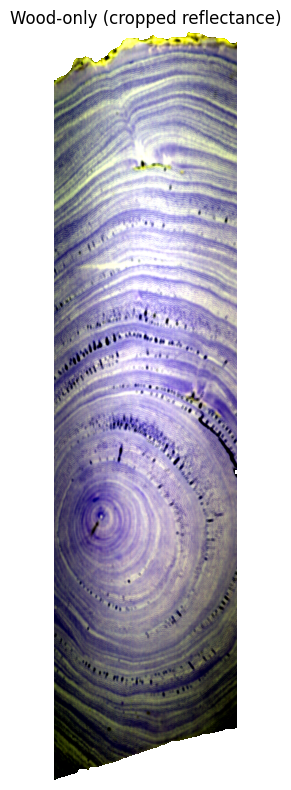

In [8]:
# Cell 8 — wood-only crop, then commit to cropped arrays for ALL later steps
def pick_bands_by_nm(w, targets_nm):
    return [int(np.argmin(np.abs(w - t))) for t in targets_nm]

def make_rgb(arr, bands):
    sub = arr[:, :, bands].astype(np.float32).copy()
    rgb = np.empty_like(sub)
    for k in range(3):
        ch = sub[:, :, k]
        vmin = np.nanpercentile(ch, 2)
        vmax = np.nanpercentile(ch, 98)
        rgb[:, :, k] = (ch - vmin) / (vmax - vmin + 1e-9)
    return np.clip(rgb, 0, 1)

# 1) wood mask on ~1100 nm
b1100 = int(np.argmin(np.abs(wavs - 1100)))
band_s = gaussian(np.nan_to_num(reflect[:, :, b1100]), sigma=2, preserve_range=True)
t = threshold_otsu(band_s)
mask = band_s > t
mask = closing(mask, rectangle(5,5))
mask = remove_small_objects(mask, min_size=5000)
mask = binary_fill_holes(mask)

lab = label(mask); regs = regionprops(lab)
if not regs: raise RuntimeError("Wood mask not found—adjust thresholding.")
largest = max(regs, key=lambda r: r.area)
wood_mask = (lab == largest.label)

# 2) crop
minr, minc, maxr, maxc = largest.bbox
reflect_wood  = reflect[minr:maxr, minc:maxc, :].copy()
radiance_wood = cube   [minr:maxr, minc:maxc, :].copy()
wood_mask_crop = wood_mask[minr:maxr, minc:maxc].copy()
reflect_wood[~wood_mask_crop] = np.nan
Hc, Wc, Bc = reflect_wood.shape

# 3) center + radius
cy_local, cx_local = map(int, regionprops(label(wood_mask_crop))[0].centroid)
Rmax_local = int(distance_transform_edt(wood_mask_crop)[cy_local, cx_local])

# 4) save exactly one NPZ (only cropped reflectance)
npz_path = ODIR_CUBES / "cube_norm_crop.npz"
np.savez_compressed(npz_path, cube=reflect_wood.astype(np.float32))
print("Saved NPZ with ONLY key 'cube':", npz_path)

# 5) quick cropped RGB
bands_rgb = pick_bands_by_nm(wavs, [1700, 1450, 1100])
rgb_wood = make_rgb(reflect_wood, bands_rgb)
plt.figure(figsize=(4,8))
plt.imshow(rgb_wood); plt.title("Wood-only (cropped reflectance)"); plt.axis("off")
plt.tight_layout(); plt.savefig(ODIR_IMG / "wood_cropped_false_color.png", dpi=200); plt.show()

# 6) metadata (small JSON, no blobs)
with open(ODIR_LOGS / "crop_meta.json", "w") as f:
    json.dump({
        "shape_reflect_crop": list(reflect_wood.shape),
        "bbox_rowcol": [int(minr), int(minc), int(maxr), int(maxc)],
        "center_local_rc": [int(cy_local), int(cx_local)],
        "rmax_local_px": int(Rmax_local),
        "rgb_bands_nm": [float(wavs[i]) for i in bands_rgb],
        "note": "All subsequent analysis uses CROPPED arrays."
    }, f, indent=2)


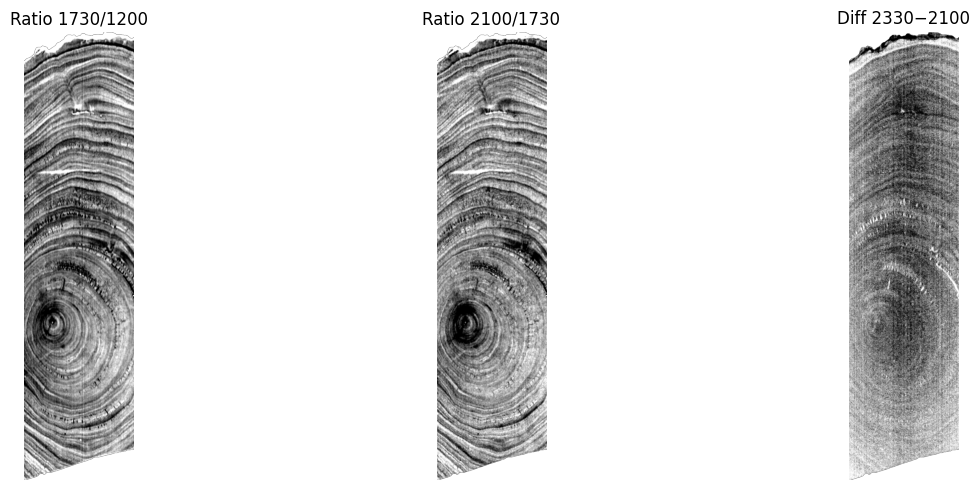

In [9]:
# Cell 9 — ring indices on CROPPED reflectance
b1200 = int(np.argmin(np.abs(wavs - 1200)))
b1730 = int(np.argmin(np.abs(wavs - 1730)))
b2100 = int(np.argmin(np.abs(wavs - 2100)))
b2330 = int(np.argmin(np.abs(wavs - 2330)))

ratio_1730_1200 = reflect_wood[:, :, b1730] / (reflect_wood[:, :, b1200] + EPS)
ratio_2100_1730 = reflect_wood[:, :, b2100] / (reflect_wood[:, :, b1730] + EPS)
diff_2330_2100  = reflect_wood[:, :, b2330] -  reflect_wood[:, :, b2100]

def norm_img(x):
    vmin, vmax = np.nanpercentile(x, 2), np.nanpercentile(x, 98)
    return np.clip((x - vmin) / (vmax - vmin + 1e-9), 0, 1)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(norm_img(ratio_1730_1200), cmap="gray"); plt.title("Ratio 1730/1200"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(norm_img(ratio_2100_1730), cmap="gray"); plt.title("Ratio 2100/1730"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(norm_img(diff_2330_2100),  cmap="gray"); plt.title("Diff 2330−2100");  plt.axis("off")
plt.tight_layout(); plt.savefig(ODIR_IMG / "crop_ring_indices_maps.png", dpi=200); plt.show()


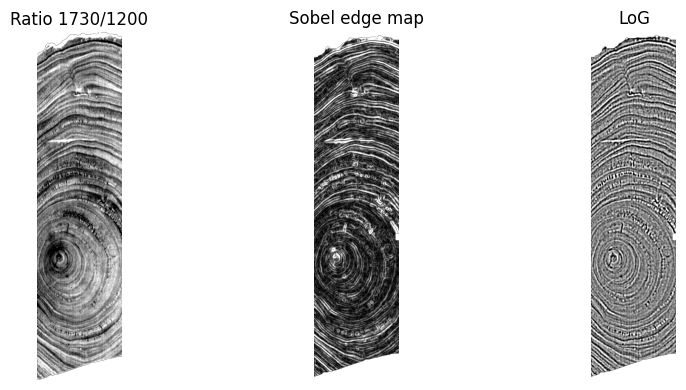

In [10]:
# Cell 10 — LoG edges on cropped ratio (1730/1200)
ring_map_c = ratio_1730_1200.copy()
edges_log_c = laplace(gaussian(ring_map_c, sigma=3))
# Smooth a bit to suppress noise
smooth = gaussian(ring_map_c, sigma=3, preserve_range=True)
# Sobel edges
edges_sobel = sobel(smooth)
def norm01(x):
    p2,p98 = np.nanpercentile(x,2), np.nanpercentile(x,98)
    return np.clip((x-p2)/(p98-p2+1e-12),0,1)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(norm01(ring_map_c),  cmap="gray"); plt.title("Ratio 1730/1200"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(norm_img(edges_sobel), cmap="gray"); plt.title("Sobel edge map"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(norm01(edges_log_c), cmap="gray"); plt.title("LoG");             plt.axis("off")

plt.tight_layout(); plt.savefig(ODIR_IMG / "crop_edge_maps.png", dpi=200); plt.show()


C:\Users\mubut0522\AppData\Local\Temp\ipykernel_33144\895954265.py:38: RuntimeWarning: Mean of empty slice
  profile = np.nanmean(polar[:, sector[0]:sector[1]], axis=1)


[Polar (crop)] R=360, sector=(233, 243), rings=19


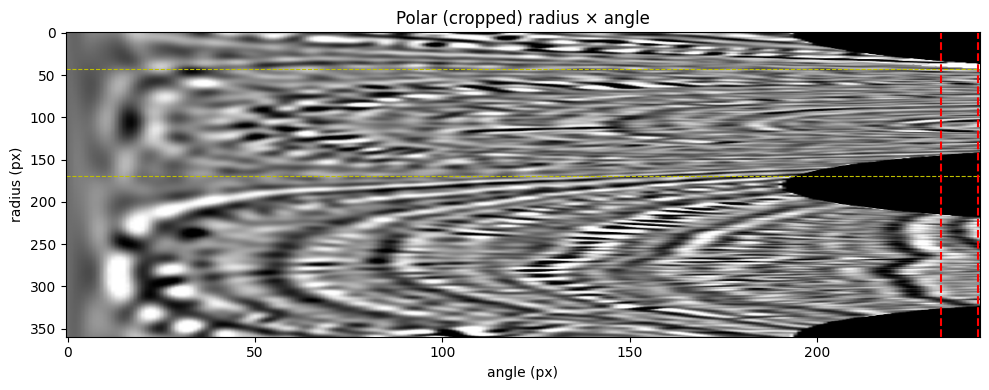

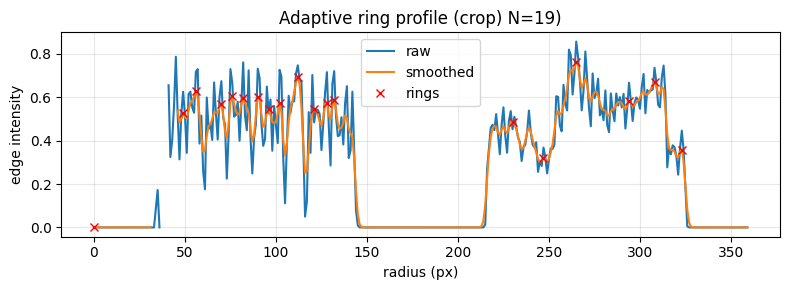

In [11]:
# Cell 12 — polar unwrap on CROPPED LoG
PARAMS = {
    "log_sigma": 3.0,
    "norm_percentiles": [2, 98],
    "sector_width_cols": 10,
    "contrast_band_pct": [0.18, 0.70],
    "peak_zones": [
        [0,   45,   3,  0.0015],
        [45,  130,  6,  0.0040],
        [130, 9999, 12, 0.0090],
    ],
    "profile_smooth_sigma": 1.2
}

def norm_img_lin(x, p=(2,98)):
    vmin, vmax = np.nanpercentile(x, p[0]), np.nanpercentile(x, p[1])
    return np.clip((x - vmin) / (vmax - vmin + 1e-9), 0, 1)

ring_base_n = norm_img_lin(edges_log_c, p=PARAMS["norm_percentiles"])

Rmax = int(distance_transform_edt(wood_mask_crop)[cy_local, cx_local])
# IMPORTANT: warp_polar center expects (row, col) = (y, x)
polar = warp_polar(ring_base_n, center=(cy_local, cx_local), radius=Rmax, scaling='linear')
R, T = polar.shape

r_lo = max(8, int(Rmax * PARAMS["contrast_band_pct"][0]))
r_hi = max(r_lo+25, int(Rmax * PARAMS["contrast_band_pct"][1]))

Wsec = PARAMS["sector_width_cols"]
scores = []
for c in range(0, max(1, T - Wsec)):
    sect = polar[r_lo:r_hi, c:c+Wsec]
    scores.append(np.nanmean(np.std(sect, axis=0)))
scores = np.asarray(scores)
c_best = int(np.nanargmax(scores))
sector = (c_best, min(T, c_best+Wsec))

profile = np.nanmean(polar[:, sector[0]:sector[1]], axis=1)
profile_s = gaussian(profile, sigma=PARAMS["profile_smooth_sigma"])

peaks2 = []
for z0, z1, distz, promz in PARAMS["peak_zones"]:
    z1 = min(z1, R)
    if z1 <= z0+2: 
        continue
    pk, _ = find_peaks(profile_s[z0:z1], distance=distz, prominence=promz)
    peaks2.extend((pk + z0).tolist())
peaks2 = np.unique(np.asarray(peaks2, dtype=int))
if (peaks2.size == 0) or (peaks2[0] > 20):
    peaks2 = np.insert(peaks2, 0, int(np.argmax(profile_s[:min(25, R)])))

print(f"[Polar (crop)] R={R}, sector={sector}, rings={len(peaks2)}")

# save figures + CSV + meta
plt.figure(figsize=(10,4))
plt.imshow(polar, aspect='auto', cmap='gray')
plt.axhline(r_lo, color='y', ls='--', lw=0.8); plt.axhline(r_hi, color='y', ls='--', lw=0.8)
plt.axvline(sector[0], color='r', ls='--');   plt.axvline(sector[1], color='r', ls='--')
plt.title("Polar (cropped) radius × angle")
plt.xlabel("angle (px)"); plt.ylabel("radius (px)")
plt.tight_layout(); plt.savefig(ODIR_RESULTS / "crop_polar_map.png", dpi=200); plt.show()

plt.figure(figsize=(8,3))
plt.plot(profile, label="raw"); plt.plot(profile_s, label="smoothed")
plt.plot(peaks2, profile_s[peaks2], "rx", label="rings")
plt.xlabel("radius (px)"); plt.ylabel("edge intensity")
plt.title(f"Adaptive ring profile (crop) N={len(peaks2)})")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig(ODIR_RESULTS / "crop_polar_profile_peaks.png", dpi=200); plt.show()

np.save(ODIR_RESULTS / "ring_radii_px.npy", peaks2)
import pandas as pd
pd.DataFrame({"ring_index": np.arange(1, len(peaks2)+1), "radius_px": peaks2}).to_csv(
    ODIR_RESULTS / "crop_rings_detected.csv", index=False
)

with open(ODIR_LOGS / "ring_detection_meta_crop.json", "w") as f:
    json.dump({
        "scan_id": SCAN_ID,
        "center_local_rc": [int(cy_local), int(cx_local)],
        "Rmax_local": int(Rmax),
        "sector_cols": list(map(int, sector)),
        "r_band_px": [int(r_lo), int(r_hi)],
        "bands_nm": {"num": float(wavs[b1730]), "den": float(wavs[b1200])},
        "params": PARAMS
    }, f, indent=2)


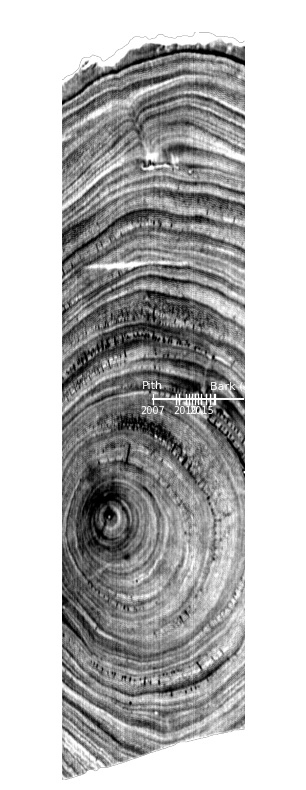

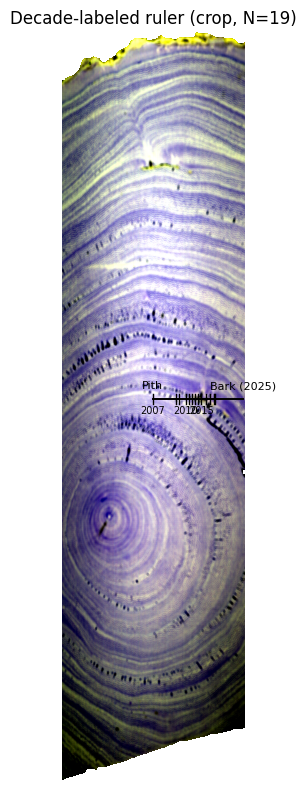

In [12]:
# Cell 13 — overlays + year labels on CROPPED images
bark_year = 2025
label_every_years = 5
tick_len = 10
line_w = 1.4

def norm_img(x, p=(2,98)):
    vmin, vmax = np.nanpercentile(x, p[0]), np.nanpercentile(x, p[1])
    return np.clip((x - vmin) / (vmax - vmin + 1e-9), 0, 1)

bg_gray = norm_img(reflect_wood[:, :, b1730] / (reflect_wood[:, :, b1200] + EPS))
bg_rgb  = rgb_wood.copy()

radii = np.asarray(np.load(ODIR_RESULTS / "ring_radii_px.npy"), dtype=int)
N = int(radii.size)
years = [bark_year - (N - i) for i in range(1, N+1)]

y0, x0 = int(cy_local), int(cx_local)
x_last = min(bg_gray.shape[1]-5, x0 + int(radii[-1]))

def draw_ruler(ax, is_gray=True):
    color = "white" if is_gray else "black"
    ax.plot([x0, x_last], [y0, y0], '-', color=color, linewidth=line_w)
    for i, (r, yr) in enumerate(zip(radii, years), start=1):
        x = x0 + int(r)
        if 0 <= x < bg_gray.shape[1]:
            ax.plot([x, x], [y0-tick_len, y0+tick_len], '-', color=color, linewidth=1)
            if yr % label_every_years == 0 or i in (1, N):
                ax.text(x, y0+tick_len+4, str(yr), ha="center", va="top", fontsize=7, color=color)
    ax.text(x0, y0-(tick_len+6), "Pith", ha="center", va="bottom", fontsize=8, color=color)
    ax.text(x_last, y0-(tick_len+6), f"Bark ({bark_year})", ha="center", va="bottom", fontsize=8, color=color)

# grayscale overlay
fig, ax = plt.subplots(figsize=(4,8))
ax.imshow(bg_gray, cmap="gray"); ax.axis("off")
draw_ruler(ax, is_gray=True)
ax.set_title(f"Decade-labeled ruler (crop, N={N})", color="white")
plt.tight_layout(); plt.savefig(ODIR_RESULTS / "crop_overlay_gray_decades.png", dpi=200, bbox_inches="tight"); plt.show()

# rgb overlay
fig, ax = plt.subplots(figsize=(4,8))
ax.imshow(bg_rgb); ax.axis("off")
draw_ruler(ax, is_gray=False)
ax.set_title(f"Decade-labeled ruler (crop, N={N})")
plt.tight_layout(); plt.savefig(ODIR_RESULTS / "crop_overlay_rgb_decades.png", dpi=200, bbox_inches="tight"); plt.show()

# CSV with years
import pandas as pd
pd.DataFrame({"ring_index": np.arange(1, N+1), "radius_px": radii, "year": years}).to_csv(
    ODIR_RESULTS / "crop_rings_detected_with_years.csv", index=False
)

# GT ruler mask
gt_mask = np.zeros(bg_gray.shape, dtype=np.uint8)
gt_mask[y0, x0:x_last+1] = 1
for r in radii:
    x = x0 + int(r)
    if 0 <= x < gt_mask.shape[1]:
        gt_mask[max(0,y0-tick_len):min(gt_mask.shape[0],y0+tick_len+1), x] = 1
np.save(ODIR_RESULTS / "crop_gt_ruler_mask.npy", gt_mask)


In [13]:
# Cell 14 — provenance
runlog = {
    "scan_id": SCAN_ID,
    "hdr_path": str(HDR_PATH),
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "shape_full": [int(H), int(W), int(B)],
    "shape_crop": [int(Hc), int(Wc), int(Bc)],
    "nm_range": [float(wavs[0]), float(wavs[-1])],
    "false_color_bands_nm": [1700.0, 1450.0, 1100.0],
    "ratio_nm": {"num": 1730.0, "den": 1200.0},
    "outputs": {
        "cube_npz": str((ODIR_CUBES / "cube_norm_crop.npz").resolve()),
        "images_dir": str(ODIR_IMG.resolve()),
        "results_dir": str(ODIR_RESULTS.resolve())
    }
}
with open(ODIR_LOGS / "runlog.json", "w") as f:
    json.dump(runlog, f, indent=2)
print("Wrote", ODIR_LOGS / "runlog.json")


Wrote results\_SWIR_384_SN3151_4000us_2025-08-27T105238_raw_rad_float32\logs\runlog.json
